---Iteration:  0
---Iteration:  1
---Iteration:  2
---Iteration:  3
---Iteration:  4
Cross Validated Estimators for Random Forest Classifier:  40

Training Confusion Matrix:
  [[27256   155]
 [   67  3413]]

Testing Confusion Matrix:
  [[8836  301]
 [ 842  318]]

Training Accuracy Score:  0.9928134408080024

Testing Accuracy Score:  0.8889967951830631

Training Precision:  0.9565582959641256

Testing Precision:  0.5137318255250404

Training Recall:  0.9807471264367816

Testing Recall:  0.27413793103448275

Train Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     27411
           1       0.96      0.98      0.97      3480

   micro avg       0.99      0.99      0.99     30891
   macro avg       0.98      0.99      0.98     30891
weighted avg       0.99      0.99      0.99     30891


Test Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94 

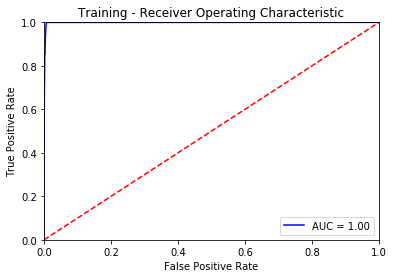

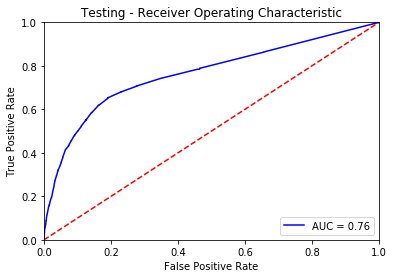

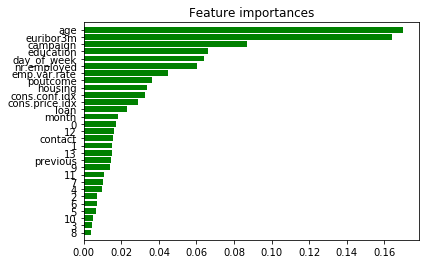

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import pickle
from src.evaluate import evaluate

from matplotlib import pyplot as plt


'''
Read preprocessed dataset
'''
df_train = pd.read_csv('./data/final/final_standardized_train.csv')
df_test = pd.read_csv('./data/final/final_standardized_test.csv')

'''
Set features and target columns
'''
df_train_class = pd.DataFrame(df_train['y'])
df_train_features = df_train.loc[:, df_train.columns != 'y']

df_test_class = pd.DataFrame(df_test['y'])
df_test_features = df_test.loc[:, df_test.columns != 'y']


n_estimators_list = range(10, 50, 10)

skf_model = StratifiedKFold(n_splits=5,shuffle=True)

'''
Iteration stop
'''
iterations = 5

for i in range(0, iterations):
    print ("---Iteration: ", i)
    avg_acc = np.zeros(shape=[len(n_estimators_list)])
    std_acc = np.zeros(shape=[len(n_estimators_list)])

    x = 0
    for k in n_estimators_list:
        temp_accuracy_list = []

        for train_subset_index, cv_index in skf_model.split(df_train_features,df_train_class):
            df_train_features_subset = df_train_features.loc[train_subset_index]
            df_train_class_subset = df_train_class.loc[train_subset_index]
            df_train_features_cv = df_train_features.loc[cv_index]
            df_train_class_cv = df_train_class.loc[cv_index]

            rf_model = RandomForestClassifier(n_estimators=k, class_weight='balanced')
            rf_model.fit(df_train_features_subset, df_train_class_subset.values.ravel())
            score_value = rf_model.score(df_train_features_cv, df_train_class_cv)
            temp_accuracy_list.append(score_value)

        avg_acc[x] = np.mean(temp_accuracy_list)
        std_acc[x] = np.std(temp_accuracy_list)
        x += 1

    if i==0:
        final_avg_acc = avg_acc
        final_std_acc = std_acc
    else:
        final_avg_acc = np.vstack([final_avg_acc, avg_acc])
        final_std_acc = np.vstack([final_std_acc, std_acc])

final_accuracy_mean_list = np.mean(final_avg_acc, axis=0)
final_k_index = np.argmax(final_accuracy_mean_list)

chosen_k= n_estimators_list[final_k_index]
print ("Cross Validated Estimators for Random Forest Classifier: ",chosen_k)

rf_model_final = RandomForestClassifier(n_estimators=chosen_k, class_weight='balanced')
rf_model_final.fit(df_train_features, df_train_class.values.ravel())

predicted_train = rf_model_final.predict(df_train_features)
predicted_test = rf_model_final.predict(df_test_features)

predicted_prob_train = rf_model_final.predict_proba(df_train_features)
predicted_prob_test = rf_model_final.predict_proba(df_test_features)

# filename = ('./model/rf/benchmark_rf_standardized_model.sav')
# pickle.dump(rf_model_final, open(filename, 'wb'))

with open('./models/rf/final_rf_standardized_model.sav', 'wb') as f:
    pickle.dump(rf_model_final, f)

evaluate(df_train_class, predicted_train, predicted_prob_train, df_test_class, predicted_test, predicted_prob_test, 'y')

for name, importance in zip(df_test_features, rf_model_final.feature_importances_):
    print(name, "=", importance)

# features = df_test_features.columns.values
# importances = rf_model_final.feature_importances_
# indices = np.argsort(importances)

# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

features = df_test_features.columns.values
importances = rf_model_final.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(df_test_features.shape[1]), importances[indices],
       color="g", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(df_test_features.shape[1]), [features[i] for i in indices])
plt.ylim([-1, df_test_features.shape[1]])
plt.show()